In [1]:
import pandas as pd
import numpy as np
import cv2, os, shutil, math
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [3]:
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def make_dataframes(sdir):
    bad_images = []  # Giữ lại nếu có ảnh bị lỗi, nhưng không cần xử lý
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))  # Lấy danh sách các lớp bệnh (thư mục con)
    
    # Duyệt qua các thư mục bệnh
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        if not os.path.isdir(classpath):  # Nếu không phải thư mục thì bỏ qua
            continue
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        
        # Duyệt qua từng tệp trong thư mục
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            try:
                # Đọc ảnh mà không cần kiểm tra phần mở rộng
                img = cv2.imread(fpath)
                shape = img.shape  # Lấy kích thước ảnh
                filepaths.append(fpath)
                labels.append(klass)
            except Exception as e:
                bad_images.append(fpath)  # Lưu lại ảnh bị lỗi
                print(f'Defective image file: {fpath}, Error: {e}')
    
    # Tạo DataFrame từ danh sách filepaths và labels
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    
    # Chia dữ liệu thành train, validation và test (80-10-10)
    train_df, dummy_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
    
    # Tính toán một số thông số về dữ liệu
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)
    
    ht, wt, count = 0, 0, 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h, w = img.shape[:2]
            ht += h
            wt += w
            count += 1
        except:
            pass
    if count > 0:
        ave_height = ht // count
        ave_width = wt // count
        aspect_ratio = ave_height / ave_width
    else:
        ave_height, ave_width, aspect_ratio = 0, 0, 0
    
    # Hiển thị thông tin thống kê
    print(f'Number of classes in processed dataset: {class_count}')
    counts = list(train_df['labels'].value_counts())
    print(f'Max files in any class in train_df: {max(counts)}, Min files in any class: {min(counts)}')
    print(f'Train dataset length: {len(train_df)}, Test dataset length: {len(test_df)}, Validation dataset length: {len(valid_df)}')
    print(f'Average image height: {ave_height}, Average image width: {ave_width}, Aspect ratio (height/width): {aspect_ratio}')
    
    return train_df, test_df, valid_df, classes, class_count

# Đọc và chia dữ liệu
sdir = 'D:/2011/folder1'  # Đường dẫn tới thư mục ảnh
train_df, test_df, valid_df, classes, class_count = make_dataframes(sdir)


scab                   : 100%|██████████████████████████████████████████| 3673/3673 [03:58<00:00, 15.42file/s]


Number of classes in processed dataset: 6
Max files in any class in train_df: 2938, Min files in any class: 949
Train dataset length: 11989, Test dataset length: 1499, Validation dataset length: 1499
Average image height: 2205, Average image width: 3258, Aspect ratio (height/width): 0.6767955801104972


In [4]:
n=2500
batch_size = 32
working_dir=r'./'
img_size=(300, 300)
epochs = 50
input_shape = (300, 300, 3)


def balance(df, n, working_dir, img_size):
    df = df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)

    for label in df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)
    total = 0
    gen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,  # Thêm shear
    fill_mode='reflect',  # Thay đổi từ 'nearest' sang 'reflect'
    brightness_range=[0.8, 1.2],  # Thêm brightness augmentation
    channel_shift_range=50.0,  # Thêm channel shift
    validation_split=0.2
    )
    groups = df.groupby('labels')
    for label in df['labels'].unique():
        group = groups.get_group(label)
        sample_count = len(group)
        if sample_count < n:
            aug_img_count = 0
            delta = n - sample_count
            target_dir = os.path.join(aug_dir, label)
            msg = '{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='')  # prints over on the same line
            aug_gen = gen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=img_size,
                                              class_mode=None, batch_size=batch_size, shuffle=False,
                                              save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                              save_format='jpg')
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count
    print('Total Augmented images created= ', total)
    aug_fpaths, aug_labels = [], []
    classlist = os.listdir(aug_dir)
    for target in classlist:
        classpath = os.path.join(aug_dir, target)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(target)
    Fseries = pd.Series(aug_fpaths, name='filepaths')
    Lseries = pd.Series(aug_labels, name='labels')
    aug_df = pd.concat([Fseries, Lseries], axis=1)
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is ', len(df))
    return df


train_df = balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  11989
Found 2368 validated image filenames.    for class            healthy             creating  132  augmented images 
Found 2001 validated image filenames.    for class              rust              creating  499  augmented images 
Found 1189 validated image filenames.    for class           Black Rot            creating 1311  augmented images 
Found 949 validated image filenames.     for class         powdery_mildew         creating 1551  augmented images 
Total Augmented images created=  3546
Length of augmented dataframe is  15535


In [7]:
# Cell 5 (cập nhật)

# Import preprocess_input cho Xception
from tensorflow.keras.applications.xception import preprocess_input

def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    # Thêm preprocess_input vào ImageDataGenerator
    # train_df đã được cân bằng và augment ở cell 4, nên trgen ở đây có thể chỉ cần preprocess_input
    # Tuy nhiên, giữ lại horizontal_flip cũng không sao và có thể giúp thêm một chút.
    trgen = ImageDataGenerator(
        horizontal_flip=True,
        preprocessing_function=preprocess_input # THÊM DÒNG NÀY
    )
    # t_and_v_gen cho validation và test không cần augmentation, chỉ cần preprocessing
    t_and_v_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input # THÊM DÒNG NÀY
    )
    
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\\r', end='')
    train_ds = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=True)

    msg = '{0:70s} for valid generator'.format(' ')
    print(msg, '\\r', end='')
    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    # Đảm bảo test_len > 0 trước khi tìm test_batch_size
    if test_len == 0:
        print("Test dataset is empty. Setting test_batch_size to 1.")
        test_batch_size = 1 # Hoặc một giá trị mặc định phù hợp
    else:
        test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                                  if test_len % n == 0 and test_len / n <= 80], reverse=True)
        if not test_batch_size: # Nếu không tìm được ước số phù hợp (ví dụ test_len quá nhỏ)
             test_batch_size = 1 # Hoặc xử lý theo cách khác
        else:
            test_batch_size = test_batch_size[0]

    test_steps = int(test_len / test_batch_size) if test_batch_size > 0 else 0
    
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\\r', end='')
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', batch_size=test_batch_size, # Sử dụng test_batch_size đã tính
                                               shuffle=False)

    classes = list(train_ds.class_indices.keys())
    class_count_from_gen = len(classes) # Lấy class_count từ generator để đảm bảo khớp
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count_from_gen)

    return train_ds, test_ds, valid_ds
    
# Sau khi định nghĩa lại hàm, chạy lại cell này để tạo train_ds, test_ds, valid_ds mới
train_ds, test_ds, valid_ds = make_gens(batch_size, train_df, test_df, valid_df, img_size)

                                                                       for train generator \rFound 15535 validated image filenames belonging to 6 classes.
                                                                       for valid generator \rFound 1499 validated image filenames belonging to 6 classes.
                                                                       for test generator \rFound 1499 validated image filenames belonging to 6 classes.
test batch size:  1 test steps:  1499 number of classes :  6


In [1]:
# Import các thư viện cần thiết (một số có thể đã có ở cell 1)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception # Thay VGG19 bằng Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout # GlobalAveragePooling2D thường dùng với Xception
from tensorflow.keras.optimizers import Adam # Sử dụng Adam optimizer
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

print("Đang triển khai mô hình Xception với Fine-tuning...")

# Các biến input_shape, class_count, train_ds, valid_ds được lấy từ các cell trước

# --- GIAI ĐOẠN 1: HUẤN LUYỆN TOP LAYERS ---
print("\\n--- GIAI ĐOẠN 1: HUẤN LUYỆN TOP LAYERS ---")

# 1. Tải Xception pre-trained model
base_model_xception = Xception(
    weights="imagenet",
    input_shape=input_shape,  # input_shape từ cell 4
    include_top=False  # Không bao gồm lớp classifier của ImageNet
)

# 2. Đóng băng các lớp của base_model
base_model_xception.trainable = False

# 3. Thêm các lớp tùy chỉnh lên trên
inputs = keras.Input(shape=input_shape)
x = base_model_xception(inputs, training=False) # Quan trọng: training=False khi base_model bị đóng băng
x = GlobalAveragePooling2D(name='xception_glob_avg_pool')(x)
x = Dense(256, activation="relu", name='xception_fc1')(x) # Lớp Dense trung gian
x = Dropout(0.5, name='xception_dropout_1')(x) # Thêm Dropout để giảm overfitting
# Lớp Dense cuối cùng với số units bằng class_count từ cell 3
prediction_xception = Dense(class_count, activation='softmax', name='xception_predictions')(x)

# 4. Tạo model Xception hoàn chỉnh cho giai đoạn 1
xception_model = Model(inputs=inputs, outputs=prediction_xception, name='xception_custom_phase1')

# 5. Callbacks cho giai đoạn 1
# EarlyStopping để dừng sớm nếu không cải thiện
early_stopping_phase1 = EarlyStopping(
    monitor='val_loss',
    patience=5, # Số epochs chờ nếu không cải thiện
    verbose=1,
    restore_best_weights=True # Khôi phục trọng số tốt nhất
)
# ReduceLROnPlateau để giảm learning rate
reduce_lr_phase1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Giảm LR đi 5 lần
    patience=2, # Số epochs chờ nếu không cải thiện
    min_lr=0.00001, # LR tối thiểu
    verbose=1
)

# 6. Compile model cho giai đoạn 1
xception_model.compile(
    optimizer=Adam(learning_rate=0.001), # LR ban đầu cho Adam
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

# 7. In summary của model Xception (giai đoạn 1)
print("\\nCấu trúc mô hình Xception (Giai đoạn 1 - chỉ huấn luyện top layers):")
xception_model.summary()

# 8. Huấn luyện model (chỉ top layers)
epochs_phase1 = 15 # Số epochs cho giai đoạn 1, EarlyStopping có thể dừng sớm hơn
print(f"\\nBắt đầu huấn luyện Giai đoạn 1 (top layers) cho {epochs_phase1} epochs...")

history_phase1 = xception_model.fit(
    train_ds,
    epochs=epochs_phase1,
    validation_data=valid_ds,
    callbacks=[early_stopping_phase1, reduce_lr_phase1],
    verbose=1
)
print("Hoàn thành Giai đoạn 1.")

# --- GIAI ĐOẠN 2: FINE-TUNING ---
print("\\n--- GIAI ĐOẠN 2: FINE-TUNING MỘT PHẦN XCEPTION ---")

# 1. Mở băng base_model_xception.
# Quyết định số lớp từ cuối để mở băng. Xception có nhiều khối.
# Ví dụ: mở băng từ khối 'block11' trở đi (Xception có 14 khối chính)
# Tìm tên layer để bắt đầu unfreeze. Bạn có thể dùng base_model_xception.summary() để xem tên các lớp.
# Hoặc đơn giản là mở băng một số lượng lớp nhất định từ cuối.
# Xception có 132 layers. Chúng ta thử mở băng 30 layers cuối.
base_model_xception.trainable = True # Mở toàn bộ base model trước

fine_tune_at_layer = 100 # Mở băng từ lớp thứ 100 trở đi (ví dụ)
# Hoặc chọn theo tên block, ví dụ: 'block13_sepconv1_act'
# for layer in base_model_xception.layers[:fine_tune_at_layer]: # Đóng băng các lớp đầu
#    layer.trainable = False

# Một cách khác đơn giản hơn là mở băng một số khối cuối cùng.
# Xception có các khối được đặt tên từ 'block1_conv1' đến 'block14_sepconv2_bn'.
# Chúng ta sẽ mở băng từ block11 (tức là các lớp thuộc block11, block12, block13, block14 sẽ được huấn luyện)
unfreeze_from_block = 'block11' # Có thể thử 'block10', 'block12', ...
print(f"Mở băng các lớp của Xception từ khối: {unfreeze_from_block}")

set_trainable = False
for layer in base_model_xception.layers:
    if unfreeze_from_block in layer.name:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# Kiểm tra lại số lượng lớp có thể huấn luyện
# for layer in base_model_xception.layers:
#    if layer.trainable:
#        print(f"Lớp {layer.name} có thể huấn luyện.")


# 2. Compile lại model cho fine-tuning với learning rate rất nhỏ
xception_model.compile(
    optimizer=Adam(learning_rate=1e-5), # Learning rate rất nhỏ cho fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. In summary của model Xception (giai đoạn 2 - fine-tuning)
print("\\nCấu trúc mô hình Xception (Giai đoạn 2 - fine-tuning):")
xception_model.summary() # Xem lại để chắc chắn các lớp đã được mở băng đúng ý

# 4. Callbacks cho giai đoạn 2 (có thể dùng lại early_stopping hoặc tạo mới)
early_stopping_phase2 = EarlyStopping(
    monitor='val_loss',
    patience=8, # Tăng patience một chút cho fine-tuning
    verbose=1,
    restore_best_weights=True
)
reduce_lr_phase2 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7, # LR tối thiểu cho fine-tuning có thể nhỏ hơn nữa
    verbose=1
)

# 5. Tiếp tục huấn luyện (fine-tuning)
epochs_phase2 = 25 # Số epochs cho giai đoạn 2 (có thể nhiều hơn giai đoạn 1)
# epochs_initial = epochs_phase1 # Số epoch đã chạy ở phase 1
# Nếu EarlyStopping ở phase 1 dừng sớm, lấy số epoch thực tế:
epochs_initial = len(history_phase1.history['loss'])


print(f"\\nBắt đầu huấn luyện Giai đoạn 2 (fine-tuning) cho {epochs_phase2} epochs...")
history_phase2 = xception_model.fit(
    train_ds,
    epochs=epochs_phase2, # epochs_initial + epochs_phase2 nếu muốn tổng số epoch
    initial_epoch=0, # history_phase1.epoch[-1] nếu muốn tiếp tục từ epoch cuối của phase 1 và dùng tổng epochs
    validation_data=valid_ds,
    callbacks=[early_stopping_phase2, reduce_lr_phase2],
    verbose=1
)
print("Hoàn thành Giai đoạn 2 (Fine-tuning).")

# (Tùy chọn) Kết hợp history nếu muốn vẽ biểu đồ tổng thể
# combined_history = {}
# for key in history_phase1.history.keys():
#    combined_history[key] = history_phase1.history[key] + history_phase2.history[key]
# total_epochs_run = len(combined_history['loss'])
# plot_auc_loss({'history': combined_history}, epochs=total_epochs_run) # Điều chỉnh hàm plot_auc_loss cho phù hợp

# Bây giờ bạn có thể dùng hàm plot_auc_loss (từ cell 7) để xem kết quả của history_phase2
# Ví dụ: plot_auc_loss(history_phase2, epochs=len(history_phase2.history['loss']))

# Và hàm predictor (từ cell 8) để đánh giá mô hình xception_model trên test_ds
# Ví dụ: predictor(test_ds) # Lưu ý: hàm predictor hiện tại dùng biến 'net', bạn cần sửa nó để nhận model làm tham số
# Hoặc bạn có thể thay đổi tên biến `net` trong hàm predictor thành `xception_model` tạm thời để chạy.
# Ví dụ: thay `net.predict(test_ds)` thành `xception_model.predict(test_ds)` trong hàm predictor.

Đang triển khai mô hình Xception với Fine-tuning...
\n--- GIAI ĐOẠN 1: HUẤN LUYỆN TOP LAYERS ---


NameError: name 'input_shape' is not defined

Tổng số epochs đã chạy (phase 1 + phase 2): 28
Number of epochs: 28
Training loss data points: 28
Validation loss data points: 28


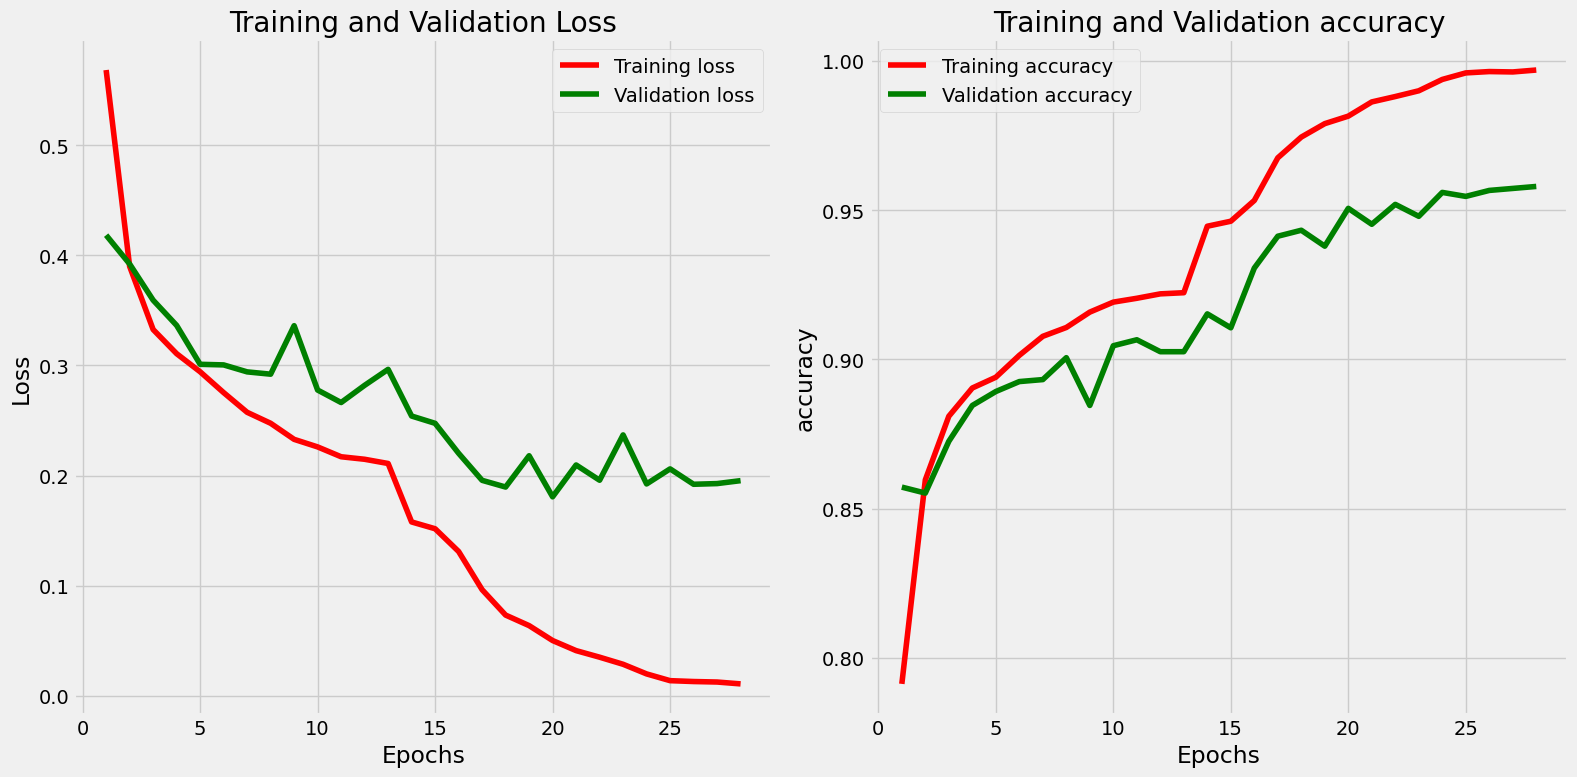

Number of epochs: 13
Training loss data points: 13
Validation loss data points: 13


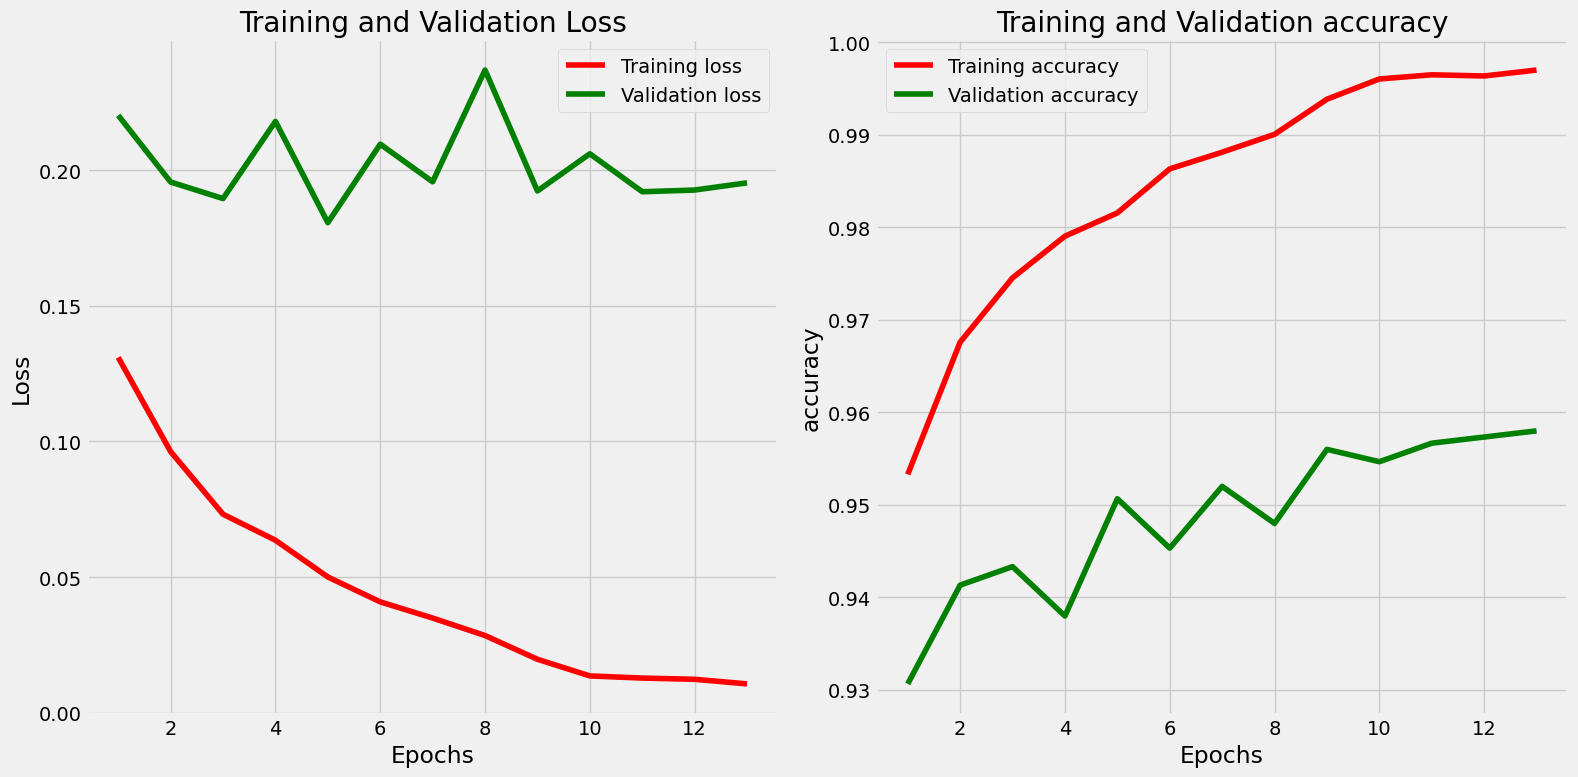

In [22]:
def plot_auc_loss(history, epochs):
    # Lấy dữ liệu từ history
    tloss = history.history['loss']  # Training loss
    vloss = history.history['val_loss']  # Validation loss

    # Kiểm tra và in ra số lượng phần tử trong các danh sách
    print(f"Number of epochs: {epochs}")
    print(f"Training loss data points: {len(tloss)}")
    print(f"Validation loss data points: {len(vloss)}")

    # Kiểm tra rằng số phần tử trong các list khớp với số epoch
    if len(tloss) != epochs or len(vloss) != epochs:
        print("Mismatch in number of epochs and data points. Adjusting to match.")
        epochs = min(len(tloss), len(vloss))  # Điều chỉnh lại epochs nếu có sự khác biệt

    Epochs = range(1, epochs + 1)  # Tạo list Epochs có độ dài giống với loss

    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    # Vẽ biểu đồ Training Loss và Validation Loss
    axes[0].plot(Epochs, tloss[:epochs], 'r', label='Training loss')  # Cắt phần tử phù hợp với số epoch
    axes[0].plot(Epochs, vloss[:epochs], 'g', label='Validation loss')  # Cắt phần tử phù hợp với số epoch
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Vẽ biểu đồ Accuracy nếu có
    if 'accuracy' in history.history:
        tacc = history.history['accuracy']
        vacc = history.history['val_accuracy']
        axes[1].plot(Epochs, tacc[:epochs], 'r', label='Training accuracy')  # Cắt phần tử phù hợp với số epoch
        axes[1].plot(Epochs, vacc[:epochs], 'g', label='Validation accuracy')  # Cắt phần tử phù hợp với số epoch
        axes[1].set_title('Training and Validation accuracy')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('accuracy')
        axes[1].legend()

    plt.tight_layout()
    plt.show()

# Kết hợp history của phase 1 và phase 2
combined_history = {}
for key in history_phase1.history.keys():
    combined_history[key] = history_phase1.history[key] + history_phase2.history[key]

# Tạo đối tượng History giả để truyền vào hàm plot_auc_loss
class CombinedHistory:
    def __init__(self, history_dict):
        self.history = history_dict

# Tính tổng số epochs đã chạy
total_epochs_run = len(combined_history['loss'])
print(f"Tổng số epochs đã chạy (phase 1 + phase 2): {total_epochs_run}")

# Vẽ biểu đồ kết hợp của cả hai phase
plot_auc_loss(CombinedHistory(combined_history), epochs=total_epochs_run)

# Vẽ biểu đồ riêng cho phase 2 nếu cần
plot_auc_loss(history_phase2, epochs=len(history_phase2.history['loss']))


1499/1499 [==============================] - 57s 37ms/step
there were 74 errors in 1499 tests for an accuracy of  95.06%


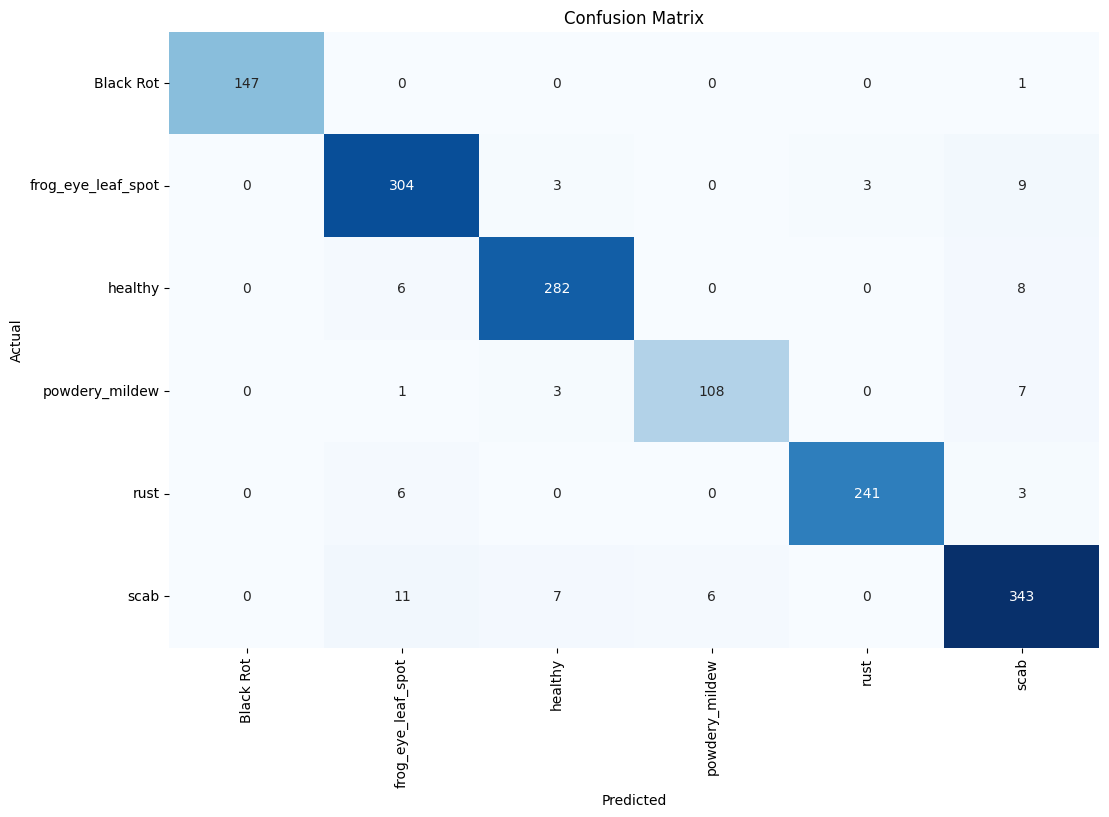

Classification Report:
----------------------
                     precision    recall  f1-score   support

         Black Rot     1.0000    0.9932    0.9966       148
frog_eye_leaf_spot     0.9268    0.9530    0.9397       319
           healthy     0.9559    0.9527    0.9543       296
    powdery_mildew     0.9474    0.9076    0.9270       119
              rust     0.9877    0.9640    0.9757       250
              scab     0.9245    0.9346    0.9295       367

          accuracy                         0.9506      1499
         macro avg     0.9571    0.9508    0.9538      1499
      weighted avg     0.9510    0.9506    0.9507      1499



In [18]:
def predictor(test_ds):
    y_pred, error_list, error_pred_list = [], [], []
    y_true = test_ds.labels
    classes = list(test_ds.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = tf.argmax(xception_model.predict(test_ds), axis=1)
    tests = len(preds)
    for i in range(tests):
        pred_index = preds[i]
        true_index = test_ds.labels[i]
        if pred_index != true_index:
            errors += 1
            file = test_ds.filenames[i]
            error_list.append(file)
            error_classes = classes[pred_index]
            error_pred_list.append(error_classes)
        y_pred.append(pred_index)

    acc = (1 - errors / tests) * 100
    msg = f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}%'
    print(msg)
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100

    if class_count <= 30:
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes, digits=4)
    print("Classification Report:\n----------------------\n", clr)

    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score = predictor(test_ds)